Epoch: 1, Loss: 153.93216904296875


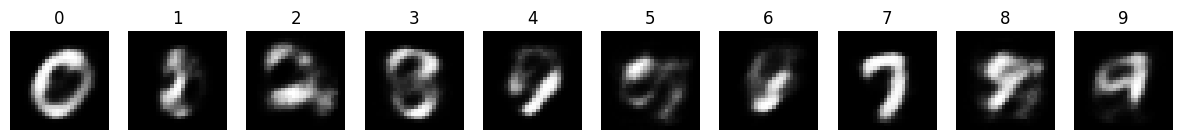

Epoch: 2, Loss: 115.80675130208333


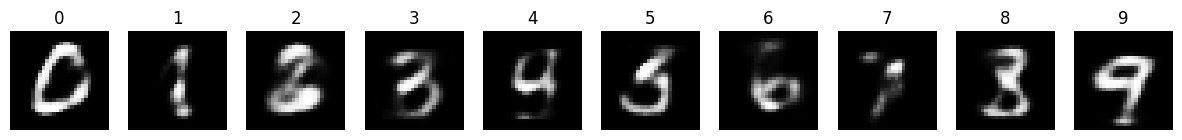

Epoch: 3, Loss: 109.31869969075521


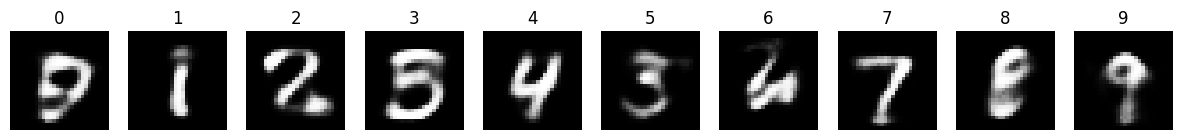

Epoch: 4, Loss: 106.45142135416667


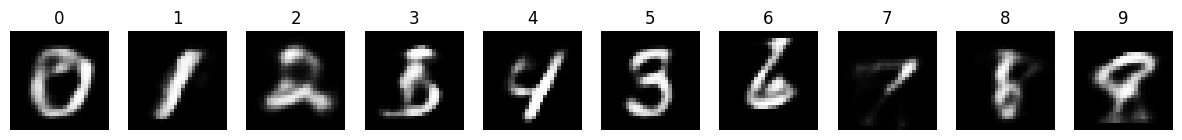

Epoch: 5, Loss: 104.734091015625


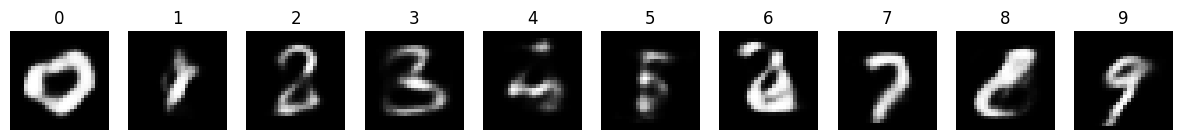

Epoch: 6, Loss: 103.5286440592448


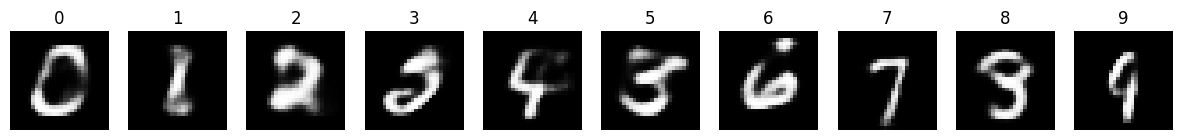

Epoch: 7, Loss: 102.69428004557291


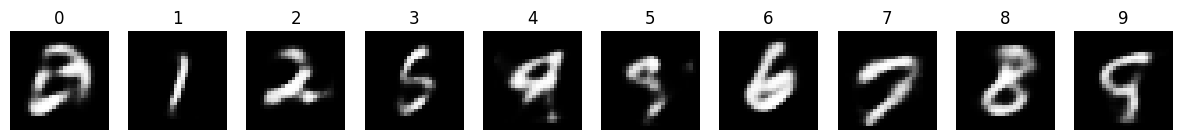

KeyboardInterrupt: 

In [1]:
import torch
from torch import nn, optim  # PyTorch modules for neural networks and optimization
from torchvision import datasets, transforms  # Modules for handling vision datasets
from torch.utils.data import DataLoader  # Utility to load data in batches
import torch.nn.functional as F  # Provides common activation functions
import matplotlib.pyplot as plt  # For plotting and visualization

# Define the Conditional Variational Autoencoder (CVAE) model
class CVAE(nn.Module):  # CVAE inherits from PyTorch's nn.Module
    def __init__(self, image_channels=1, digit_embedding_size=10, latent_dim=20): #Each image has 1 channel (grayscale)
        super(CVAE, self).__init__()
        # Fully connected layer for encoding: Input is the flattened image and a condition (label embedding)
        self.fc1 = nn.Linear(image_channels * 28 * 28 + digit_embedding_size, 512)

        # Two output layers for the encoder: one for mean (mu) and one for log variance (log_var) of the latent space
        self.fc21 = nn.Linear(512, latent_dim)  # Output: Mean of the latent space
        self.fc22 = nn.Linear(512, latent_dim)  # Output: Log variance of the latent space

        # Fully connected layers for decoding: input is the latent vector and the condition
        self.fc3 = nn.Linear(latent_dim + digit_embedding_size, 512)
        self.fc4 = nn.Linear(512, image_channels * 28 * 28)  # Reconstructs the flattened image

        # Embedding layer to map categorical labels (0-9) to a continuous vector representation
        self.digit_embedding = nn.Embedding(10, digit_embedding_size) #10 sspecifies the number of unique digits (catagorical labels), digit_embedding_size is the size that ech label is mapped to

    def encode(self, x, condition):
        """
        Encodes the input image and condition into the latent space.
        x: Flattened image.
        condition: Categorical label (digit) converted to an embedding.
        """
        # Embed the condition (categorical label) into a continuous vector
        condition_embedding = self.digit_embedding(condition)

        # Concatenate the image and the condition embedding
        x = torch.cat([x.view(-1, 28 * 28), condition_embedding], dim=1)

        # Pass through the encoder fully connected layer
        h1 = F.relu(self.fc1(x))  # Apply ReLU activation for non-linearity

        # Return the mean (mu) and log variance (log_var) for the latent space
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, log_var):
        """
        Performs the reparameterization trick to sample latent vector z.
        This allows backpropagation through the stochastic sampling step.
        """
        std = torch.exp(0.5 * log_var)  # Compute the standard deviation from log variance
        eps = torch.randn_like(std)  # Sample random noise from a normal distribution
        return mu + eps * std  # Return the sampled latent vector

    def decode(self, z, condition):
        """
        Decodes the latent vector and condition back into an image.
        z: Latent vector sampled from the latent space.
        condition: Categorical label (digit) converted to an embedding.
        """
        # Embed the condition (categorical label) into a continuous vector
        condition_embedding = self.digit_embedding(condition)

        # Concatenate the latent vector and the condition embedding
        z = torch.cat([z, condition_embedding], dim=1)

        # Pass through the decoder fully connected layers
        h3 = F.relu(self.fc3(z))  # Apply ReLU activation for non-linearity
        return torch.sigmoid(self.fc4(h3))  # Use sigmoid activation for output in range [0, 1]

    def forward(self, x, condition):
        """
        Defines the full forward pass: encode -> reparameterize -> decode.
        """
        mu, log_var = self.encode(x, condition)  # Encode the input and condition
        z = self.reparameterize(mu, log_var)  # Sample from the latent space
        return self.decode(z, condition), mu, log_var  # Decode to reconstruct the image

# Training function with image generation
def train_and_generate_images(model, train_loader, optimizer, epoch):
    model.train()  # Set the model to training mode
    train_loss = 0  # Initialize the loss for the epoch

    for batch_idx, (data, condition) in enumerate(train_loader):
        data = data.to(device)  # Send data to the device (CPU or GPU)
        condition = condition.to(device)  # Send condition (labels) to the device

        optimizer.zero_grad()  # Reset gradients for the optimizer

        # Perform forward pass
        recon_batch, mu, log_var = model(data, condition)

        # Compute the reconstruction loss (Binary Cross-Entropy between input and output)
        recon_loss = F.binary_cross_entropy(recon_batch, data.view(-1, 784), reduction='sum')

        # Compute the KL divergence for the latent space regularization
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Total loss is reconstruction loss + KL divergence
        loss = recon_loss + kl_div

        # Backpropagate the loss
        loss.backward()
        train_loss += loss.item()  # Accumulate loss
        optimizer.step()  # Update model weights

    print(f'Epoch: {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

    # Generate and display images for digits 0 to 9 at the end of each epoch
    with torch.no_grad():  # Disable gradient computation for generation
        fig, axs = plt.subplots(1, 10, figsize=(15, 1.5))  # Create a grid for visualization
        for digit in range(10):  # Generate one image per digit
            condition = torch.tensor([digit]).to(device)  # Specify the digit condition
            z = torch.randn(1, 20).to(device)  # Sample a random latent vector z, 1 sample of 20 dimensions (there are 20 dimensions in the latent space)
            sample = model.decode(z, condition).cpu().view(28, 28)  # Decode to an image
            axs[digit].imshow(sample, cmap='gray')  # Display the generated image
            axs[digit].set_title(f'{digit}')  # Label the image with the digit
            axs[digit].axis('off')  # Hide axes for better visualization
        plt.show()  # Display the generated images

# Data preprocessing and loading
transform = transforms.Compose([transforms.ToTensor()])  # Convert images to tensors
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)  # Load MNIST dataset
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)  # Create batches of size 128

# Model instantiation and optimizer setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
model = CVAE().to(device)  # Instantiate the CVAE model and send it to the device
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Use Adam optimizer with learning rate 1e-3

# Training loop with image generation
num_epochs = 20  # Train for 20 epochs
for epoch in range(1, num_epochs + 1):
    train_and_generate_images(model, train_loader, optimizer, epoch)  # Train and generate images
